# Use NCI compounds data to predict MRP7 substrates

In [1]:
import pandas as pd
import re
import numpy as np
NSC_REF_DIR = "../data/cancer_cell/nci_nsc_name.tab"
DATA_DIR = "../data/cancer_cell/mmc7.csv"

# Autoreload modules
%load_ext autoreload
%autoreload 2

from mrp7pred.utils import standardize_smiles

import warnings
warnings.filterwarnings("ignore")

## Load data and rename columns

In [2]:
# reference table
# to map the smile

df_ref = pd.read_csv(NSC_REF_DIR, sep="\t")
df_ref

,E_NSC,E_NAME,E_NAMESET(0),E_NAMESET(1),E_NAMESET(2),E_NAMESET(3),E_NAMESET(4),E_NAMESET(5),E_NAMESET(6),E_NAMESET(7),...,E_NAMESET(60),E_NAMESET(61),E_NAMESET(62),E_NAMESET(63),E_NAMESET(64),E_NAMESET(65),E_NAMESET(66),E_NAMESET(67),E_CAS,E_SMILES
0,186,"8-hydroxy-3,4,5-trimethyl-6-oxo-4,6-dihydro-3H...","8-hydroxy-3,4,5-trimethyl-6-oxo-4,6-dihydro-3H...","3H-2-Benzopyran-7-carboxylic acid, 4,6-dihydro...",Antimycin,Citriain,Citrinin,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,518-75-2,CC2=C1[C@H]([C@H](OC=C1C(=C(C(=O)O)C2=O)O)C)C
1,740,"N-(4-(((2,4-diamino-6-pteridinyl)methyl)(methy...","N-(4-(((2,4-diamino-6-pteridinyl)methyl)(methy...",Amethopterin,CL 14377,"EMT 25,299","Glutamic acid, {N-[p-[[(2,} 4-diamino-6-pterid...",HDMTX,"L-Glutamic acid, {N-[4-[[2,} 4-diamino-6-pteri...",Metatrexan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59-05-2,NC1=C2C(=NC(=N1)N)N=CC(=N2)CN(C)C3=CC=C(C(N[C@...
2,742,O-(1lambda~5~-diazenylideneacetyl)serine,O-(1lambda~5~-diazenylideneacetyl)serine (ACD/...,o-Diazoacetyl-L-serine,"Acetic acid, diazo-, ester with serine",Azaserin,Azaserine(USAN),AZASERINE,AZS,C.I. 337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115-02-6,C([C@H](COC(=O)C=[N+]=[N-])N)(=O)O
3,750,4-((methylsulfonyl)oxy)butyl methanesulfonate,4-((methylsulfonyl)oxy)butyl methanesulfonate ...,AN 33501,Busulfan,Busulphan,Buzulfan,C.B. 2041,Citosulfan,CB 2041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55-98-1,C[S](=O)(=O)OCCCCO[S](C)(=O)=O
4,752,2-amino-9H-purin-6-yl hydrosulfide,2-amino-9H-purin-6-yl hydrosulfide (ACD/Name),2-amino-9H-purine-6-thiol (ACD/Name),BW 5071,"Guanine, thio- (VAN)",Lanvis,NSC 752,"Purine-6(1H)-thione, 2-amino-","Purine-6-thiol, 2-amino-",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154-42-7,SC1=C2C(=NC(=N1)N)[NH]C=N2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,698691,No Name,???,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C12=CC=CC=C1N=C4C(=C2NC3=CC=C(C=C3)C(=O)C)CCCC4
1409,698790,26-(hexopyranosyloxy)-22-methoxyfurost-5-en-3-...,26-(hexopyranosyloxy)-22-methoxyfurost-5-en-3-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3[C@H](CC2=CC[C@H]1[C@@H]4[C@](CC[C@@H]1[C@]2...
1410,698792,3-((2-O-(6-deoxyhexopyranosyl)-3-O-hexopyranos...,3-((2-O-(6-deoxyhexopyranosyl)-3-O-hexopyranos...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C3[C@H](CC2=CC[C@H]1[C@@H]4[C@](CC[C@@H]1[C@]2...
1411,699477,No Name,???,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1=CC\4=C(C=C1)[N]2C(=CC(=[N+]2C)C3=CC=CC=C3)C...


In [3]:
nscid_smile_map = dict()
for row in df_ref.itertuples():
    nscid = getattr(row, "E_NSC")
    smile = getattr(row, "E_SMILES")
    nscid_smile_map[str(nscid)] = smile
for k, v in nscid_smile_map.items():
    print(k, v)
    print(type(k), type(v))
    break
len(nscid_smile_map)

186 CC2=C1[C@H]([C@H](OC=C1C(=C(C(=O)O)C2=O)O)C)C
<class 'str'> <class 'str'>


1413

In [4]:
# expression-sensitivity data

df = pd.read_csv(DATA_DIR)
df

,NSC No.,ABC-G8,ABC-G5,ABC-G4,ABC-G2,ABC-G1,ABC-F3,ABC-F2,ABC-F1,ABC-E1,...,ABC-A10,ABC-A9,ABC-A8,ABC-A7,ABC-A6,ABC-A5,ABC-A4,ABC-A3,ABC-A2,ABC-A1
0,2013,0.04,0.16,0.00,-0.01,-0.14,0.06,0.11,-0.22,-0.05,...,-0.08,-0.04,-0.03,0.04,-0.12,-0.02,-0.17,0.20,0.02,0.05
1,3053,-0.05,0.04,0.20,0.22,0.24,-0.21,-0.28,-0.19,-0.34,...,-0.17,0.07,0.28,-0.12,0.00,-0.10,0.14,-0.11,-0.13,-0.27
2,3970,-0.07,-0.03,-0.04,0.16,-0.24,-0.10,-0.23,-0.15,-0.39,...,-0.35,0.14,0.06,0.09,0.07,-0.07,-0.08,0.03,-0.08,-0.29
3,5890,-0.01,0.21,-0.04,0.21,-0.28,0.24,-0.03,-0.11,-0.21,...,-0.35,0.14,-0.09,0.10,0.01,0.00,0.02,0.27,0.19,-0.13
4,8120,0.14,0.02,0.05,-0.10,0.15,-0.02,0.10,0.08,0.14,...,0.09,-0.15,-0.12,-0.05,-0.21,0.07,0.07,-0.18,-0.06,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,Uk:Inosine-glycodialdehyde(118994),0.12,-0.09,0.17,-0.12,0.10,0.03,0.02,0.08,-0.03,...,0.21,-0.04,-0.11,0.23,-0.19,0.10,0.16,0.17,0.16,-0.12
1425,Urea(143147),-0.04,-0.04,-0.15,0.14,0.37,-0.09,-0.20,-0.06,-0.29,...,-0.22,-0.25,0.17,-0.22,-0.07,-0.02,0.15,0.04,0.11,-0.14
1426,Urea(292684),-0.07,-0.03,-0.11,-0.21,0.13,0.10,0.21,0.11,0.20,...,0.24,-0.21,-0.10,-0.17,0.01,0.04,0.09,0.07,-0.14,0.19
1427,Ver(126728),-0.07,0.21,-0.10,0.01,-0.20,0.07,0.14,-0.04,0.06,...,0.23,0.09,0.03,0.09,0.13,0.01,-0.23,-0.16,-0.05,-0.07


In [5]:
# Extract ABCC10 data and map smile
df_c10 = df[["NSC No.", "ABC-C10"]]
df_c10 = df_c10.rename(columns={"NSC No." : "nsc_id", "ABC-C10" : "abcc10"})
df_c10["nsc_id"] = df_c10["nsc_id"].apply(lambda x: ''.join(re.findall(r"\((\d+)\)", x)) if not x.isnumeric() else x)
df_c10['name'] = df_c10["nsc_id"].apply(lambda x: f"NSC{x}")
df_c10["smiles"] = df_c10["nsc_id"].apply(lambda x: nscid_smile_map[x] if x in nscid_smile_map else 'error')
df_c10

,nsc_id,abcc10,name,smiles
0,2013,-0.21,NSC2013,C(CCCCCCCCC(=O)O)=C
1,3053,-0.18,NSC3053,O=C(N[C@H]2C(=O)N[C@@H](C(C)C)C(=O)N1[C@H](CCC...
2,3970,-0.05,NSC3970,OC1=NC(=NC=C1)O
3,5890,0.01,NSC5890,C[C@@]23C1=C(C(=C(O)C(=C1O)C)C(C)=O)OC2=CC(=O)...
4,8120,-0.01,NSC8120,C2=C1C(=CC(=O)O1)[C@@H](O)OC2
...,...,...,...,...
1424,118994,-0.08,NSC118994,[C@H](O[C@@H](CO)C=O)(C=O)[N]2C1=C(C(=NC=N1)O)...
1425,143147,0.04,NSC143147,O=C(N[C@@H]1CC[C@@H](CC1)C[C@H]2CC[C@H](NC(N(C...
1426,292684,0.01,NSC292684,O=C(NC1CCCCC1)N(CCSCCCl)N=O
1427,126728,-0.12,NSC126728,CC12C5(C3OC4C1(COC(=O)C(O)C(C)CCOC(C=CC=CC(OC2...


In [6]:
df_c10[df_c10['smiles']=='error']

,nsc_id,abcc10,name,smiles
28,44185,-0.13,NSC44185,error
34,61586,0.06,NSC61586,error
55,100045,0.08,NSC100045,error
94,146208,0.11,NSC146208,error
104,157365,-0.12,NSC157365,error
145,237020,-0.02,NSC237020,error
253,403170,-0.36,NSC403170,error
319,621812,0.07,NSC621812,error
321,622114,0.16,NSC622114,error
322,622124,0.19,NSC622124,error


### Manual search

SMILES was generated using http://www.cheminfo.org/flavor/malaria/Utilities/SMILES_generator___checker/index.html (if not available in pubchem)

***Potential substrate only**

In [44]:
df_c10[df_c10["nsc_id"]=="403170"]["smiles"] = "CC(=O)NC3CCc1ccccc1c2ccc(N)c(=O)cc23"
# df_c10[df_c10["nsc_id"]=="652903"]["smiles"] = Not avaliable

### Drop rows without smiles

In [45]:
df_c10.drop(df_c10[df_c10['smiles']=='error'].index, inplace=True)
df_c10[df_c10['smiles']=='error']

,nsc_id,abcc10,name,smiles,label


## Threshold

Corr <= -0.2      -> Substrate

|Corr| <= 0.05.   -> Non-substrate

In [49]:
mask_sub = df_c10["abcc10"] <= -0.25

mask_del = (df_c10["abcc10"] > 0.03) | ((df_c10["abcc10"] <= -0.03) & (df_c10["abcc10"] > -0.25))

df_c10.drop(df_c10[mask_del].index, inplace=True)
df_c10["label"] = df_c10["abcc10"].apply(lambda x: 1 if x<=-0.25 else 0)

df_c10[df_c10["label"]==1], df_c10[df_c10["label"]==0], df_c10.shape

(      nsc_id  abcc10       name  \
 29     46061   -0.25   NSC46061   
 45     80469   -0.30   NSC80469   
 59    102815   -0.26  NSC102815   
 75    126765   -0.30  NSC126765   
 110   163088   -0.25  NSC163088   
 116   170365   -0.26  NSC170365   
 136   210761   -0.29  NSC210761   
 137   211500   -0.43  NSC211500   
 159   265450   -0.31  NSC265450   
 170   283440   -0.29  NSC283440   
 197   320877   -0.27  NSC320877   
 217   353076   -0.29  NSC353076   
 234   374979   -0.28  NSC374979   
 235   374980   -0.27  NSC374980   
 316   620514   -0.25  NSC620514   
 328   622688   -0.26  NSC622688   
 347   625502   -0.25  NSC625502   
 375   630678   -0.26  NSC630678   
 394   634791   -0.26  NSC634791   
 397   636679   -0.36  NSC636679   
 495   645033   -0.26  NSC645033   
 516   645806   -0.25  NSC645806   
 553   647939   -0.34  NSC647939   
 629   665299   -0.34  NSC665299   
 656   668380   -0.30  NSC668380   
 702   682066   -0.31  NSC682066   
 734   687744   -0.25  NSC68

## Predict using MRP7Pred

In [53]:
# df_c10_feats = pd.read_csv("./nsc_substrate__full_features_831_20210306-094650.csv", index_col=0)
# df_c10_feats

# df_c10_feats = pd.read_csv("./nsc_substrate_500__full_features_831_20210306-160552.csv", index_col=0)
# df_c10_feats

# df_c10_feats = pd.read_csv("./nsc_substrate_260__full_features_831_20210306-165531.csv", index_col=0)
# df_c10_feats

df_c10_feats = pd.read_csv("./nsc_substrate_130__full_features_831_20210306-173504.csv", index_col=0)
df_c10_feats

,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,rdk_NumAliphaticRings,rdk_NumAromaticCarbocycles,...,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,name,smiles,label
0,0.333333,25,328.191,2,7,3,1,1,2,1,...,3.591,3.733,3.656,3.492,3.142,2.696,2.151,NSC5890,CC(=O)c1c(O)c(C)c(O)c2c1OC1=CC(=O)[C@@H](C(C)=...,0
1,0.250000,10,128.086,0,2,1,1,0,1,0,...,2.551,2.373,1.572,0.791,0.000,0.000,0.000,NSC15309,CC1=CC(=O)C(C)=CC1=O,0
2,0.055556,19,230.205,0,1,4,0,0,0,2,...,3.450,3.541,3.363,3.085,2.811,2.398,1.609,NSC28002,Cc1c2ccc3ccccc3c2c[n+]2ccccc12,0
3,0.173913,27,336.265,0,4,4,1,0,1,2,...,3.669,3.768,3.716,3.607,3.514,3.439,3.212,NSC80469,CC(C)[n+]1c2c(n(C)c1/C=C/c1ccccc1)C(=O)c1ccccc...,1
4,0.800000,14,180.122,2,4,0,0,0,0,0,...,2.396,2.318,2.215,2.099,1.968,1.841,1.641,NSC95580,CC(=O)NCCCCCCNC(C)=O,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.468750,46,624.406,3,13,8,1,4,5,2,...,4.167,4.193,4.236,4.307,4.306,4.253,4.035,NSC122819,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@H]3O[C@H]5C...,1
101,0.666667,18,240.138,3,9,1,0,0,0,0,...,2.855,2.824,2.836,2.707,2.744,1.865,0.482,NSC283162,CN(CO)c1nc(N(C)CO)nc(N(C)CO)n1,0
102,0.454545,76,994.592,4,21,7,3,1,4,3,...,4.539,4.728,4.844,4.992,5.119,5.135,5.142,NSC600222,CC(=O)O[C@@H]1C(=O)[C@]2(C)[C@H](OC(=O)CCC(=O)...,1
103,0.000000,13,188.171,4,5,1,0,0,0,0,...,2.573,2.387,2.113,1.954,2.051,2.025,1.186,NSC95678,NC(=S)N/N=C/c1ncccc1O,0


Calculating correlation matrix ... Done!
Creating correlation graph ... Done!
Selected 424/828 features
Drop nan ... Done!
Spliting training and test data ... 
Done!
train_1: 24; train_0: 46; test_1: 12; test_0: 18
Start training ... Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:    3.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    5.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    7.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    8.0s finished


Best score: 0.7857142857142858
Done!
Best model:
Pipeline(steps=[('fsel',
                 FeatureSelector(selected_feature_id=array([  0,   6,   7,   8,   9,  10,  17,  18,  19,  23,  24,  25,  26,
        28,  30,  34,  35,  36,  37,  38,  39,  40,  44,  45,  46,  47,
        49,  50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  81,  82,  83,  84,  85,  86,  90,  91,  92,  93,  94,  97,
        98,  99, 100, 102, 103, 104, 105, 130, 132, 133, 162, 167, 168,
       169, 173, 174, 184, 185, 186, 187, 192, 197, 202, 205...
       690, 691, 693, 694, 695, 696, 697, 700, 701, 702, 706, 707, 711,
       712, 713, 714, 715, 718, 720, 723, 724, 725, 727, 729, 730, 731,
       732, 733, 734, 735, 736, 737, 739, 740, 744, 745, 746, 747, 749,
       750, 751, 754, 755, 756, 758, 760, 761, 762, 763, 764, 765, 766,
       767, 768, 769, 770, 771, 772, 773, 774, 776, 777, 778, 779, 780,
       781, 782, 

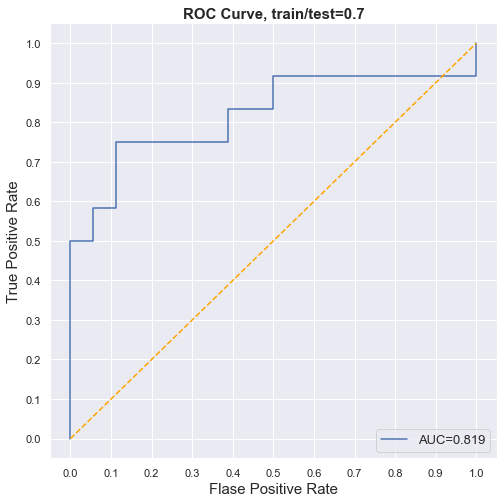

Done!


In [60]:
from mrp7pred.mrp7pred import MRP7Pred
from mrp7pred.grid import grid_light, grid_light_imbalance

m7p = MRP7Pred(train_new = True)
m7p.auto_train_test(
    df = df_c10_feats,
    grid = grid_light,
    model_dir = ".",
    feats_dir = ".",
    train_test_ratio = 0.7,
    featurized = True,
#     random_state = 1214,
    prefix = "nsc_substrate_130_",
    time_limit=15,
    scoring='precision',
)
clf = m7p.clf_best

## Predict unknown

In [33]:
df_unk = pd.read_csv("./featurized_unknown__full_features_828_20210206-132138.csv", index_col=0)
df_unk

,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,rdk_NumAliphaticRings,rdk_NumAromaticCarbocycles,...,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,name,smiles
0,0.250000,33,441.749,3,8,3,0,0,0,2,...,3.424,3.643,3.663,3.678,3.775,3.713,3.438,3.179,Citarinostat,O=C(CCCCCCNC(=O)c1cnc(N(c2ccccc2)c2ccccc2Cl)nc...
1,0.083333,21,298.215,1,8,2,0,0,0,1,...,2.934,3.173,3.062,3.005,2.977,2.858,2.673,2.456,Nitazoxanide,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1
2,0.181818,28,350.276,2,6,5,0,1,1,1,...,3.362,3.707,3.748,3.724,3.779,3.764,3.591,3.219,Galunisertib,Cc1cccc(-c2nn3c(c2-c2ccnc4ccc(C(N)=O)cc24)CCC3)n1
3,0.280000,37,522.218,3,9,4,0,1,1,2,...,3.523,3.851,3.916,3.784,3.701,3.703,3.626,3.474,Ensartinib,CC(Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2)nnc1...
4,0.260870,30,385.269,3,6,5,1,0,1,2,...,3.373,3.663,3.630,3.575,3.582,3.555,3.498,3.300,Anlotinib,COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ccnc2cc1OCC1(N)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.363636,31,422.718,1,7,4,0,1,1,2,...,3.329,3.630,3.658,3.497,3.478,3.485,3.488,3.393,Gefitinib,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
73,0.272727,29,370.259,1,7,3,0,0,0,2,...,3.234,3.502,3.564,3.478,3.522,3.547,3.491,3.318,Erlotinib,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
74,0.240000,35,490.220,2,7,5,0,1,1,2,...,3.526,3.872,3.961,3.905,3.806,3.700,3.569,3.455,FRAX486,CCn1c(=O)c(-c2ccc(Cl)cc2Cl)cc2cnc(Nc3ccc(N4CCN...
75,0.066667,22,304.651,2,5,3,0,0,0,1,...,3.060,3.348,3.372,3.324,3.276,3.192,2.941,2.447,AZD4635,Cc1cc(-c2nnc(N)nc2-c2ccc(F)cc2)cc(Cl)n1


In [34]:
# test on known dataset
df_man = pd.read_csv("./man_full_features_828_20210115-085233.csv", index_col=0)
df_man = df_man.rename(columns={"std_smiles":"smiles"})
df_man

,name,smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe7,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.327,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.285,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.247,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.890,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,2.614,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,3.181,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.969,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,3.108,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412
115,CCTA-49,O=C(Nc1cccc(-c2ccc(-c3ccccc3)c(F)c2)c1)C(Cl)Cl,0.050000,25.0,360.130,1.0,2.0,3.0,0.0,0.0,...,3.297,3.192,3.277,3.563,3.536,3.431,3.414,3.222,3.091,3.035


In [61]:
result_df = m7p.predict(
        compound_df = df_man,
        featurized_df = df_man,
        prefix = "man_substrate_130_",
        out_dir = "."
    )

Start predicting ... Done!
Writing output ... Done! Results saved to: ./man_substrate_130_predicted_20210306-175313.csv


In [62]:
result_df = m7p.predict(
        compound_df = df_unk,
        featurized_df = df_unk,
        prefix = "unknown_nsc_substrate_130_",
        out_dir = "."
    )

Start predicting ... Done!
Writing output ... Done! Results saved to: ./unknown_nsc_substrate_130_predicted_20210306-175314.csv


# Use abcc10 < -0.25 plus manual negative data to predict substrate

The reason is low correlation between RNA expression and sensitivity does not guarantee non-substrate. There might be some trade-off mechanisms.

In [67]:
df_abcc10_pos = df_c10_feats[df_c10_feats["label"]==1]
df_neg_label = pd.read_csv("../data/manual/negative.csv")
df_manual_feats = pd.read_csv("./man_full_features_828_20210115-085233.csv", index_col=0)
df_neg = df_manual_feats[df_manual_feats["name"].isin(df_neg_label["compound_name"])]
df_neg = df_neg.rename(columns={"std_smiles":"smiles"})
df_neg["label"] = 0
df_sub_merged = df_abcc10_pos.append(df_neg, ignore_index=True)
df_sub_merged

,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,rdk_NumAliphaticRings,rdk_NumAromaticCarbocycles,...,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,name,smiles,label
0,0.173913,27.0,336.265,0.0,4.0,4.0,1.0,0.0,1.0,2.0,...,3.669,3.768,3.716,3.607,3.514,3.439,3.212,NSC80469,CC(C)[n+]1c2c(n(C)c1/C=C/c1ccccc1)C(=O)c1ccccc...,1
1,0.500000,43.0,566.325,5.0,13.0,6.0,2.0,2.0,4.0,2.0,...,4.151,4.353,4.340,4.266,4.104,3.982,3.856,NSC102815,COC(=O)[C@@H]1c2cc3c(c(O)c2[C@@H](OC)C[C@]1(C)...,1
2,0.772727,31.0,408.233,3.0,9.0,5.0,3.0,2.0,5.0,0.0,...,3.877,4.108,4.117,3.906,3.698,3.154,2.578,NSC126765,CC(=O)O[C@H]1C(=O)O[C@@H]2C[C@H]3C(C)=CC(=O)[C...,1
3,0.250000,25.0,318.223,0.0,5.0,5.0,0.0,2.0,2.0,2.0,...,3.620,3.709,3.565,3.422,3.226,2.977,2.684,NSC163088,COc1ccc2cc3[n+](cc2c1OC)CCc1cc2c(cc1-3)OCO2,1
4,0.430556,114.0,1579.242,18.0,37.0,10.0,1.0,4.0,5.0,0.0,...,4.981,5.093,5.230,5.331,5.392,5.458,5.498,NSC170365,C=C(NC(=O)C(=C)NC(=O)c1csc(C2=N[C@@H]3c4csc(n4...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,0.0,2.0,...,3.254,3.163,3.045,3.063,2.856,2.604,2.351,CCTA-45,O=C(Nc1cccc(-c2cc(F)cc(F)c2)c1)C(Cl)Cl,0
99,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,0.0,2.0,...,3.278,3.198,3.060,3.078,2.892,2.650,2.399,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0
100,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,0.0,2.0,...,3.254,3.177,3.055,3.067,2.849,2.590,2.365,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0
101,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,0.0,2.0,...,3.278,3.211,3.075,3.078,2.885,2.636,2.412,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0


Calculating correlation matrix ... Done!
Creating correlation graph ... Done!
Selected 414/828 features
Drop nan ... Done!
Spliting training and test data ... 
Done!
train_1: 27; train_0: 42; test_1: 9; test_0: 21
Start training ... Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:    5.5s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:    6.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    8.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    9.1s finished


Best score: 0.8835164835164834
Done!
Best model:
Pipeline(steps=[('fsel',
                 FeatureSelector(selected_feature_id=array([  0,   6,   7,   8,   9,  10,  11,  16,  17,  18,  19,  23,  24,
        25,  30,  33,  34,  35,  36,  38,  39,  40,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  81,  82,  83,  84,  85,  86,  90,  91,  92,  93,  94,
        97,  98, 100, 101, 102, 103, 104, 105, 106, 130, 138, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 160, 162...
       674, 675, 676, 677, 678, 679, 680, 681, 683, 684, 685, 686, 690,
       691, 692, 693, 694, 695, 696, 697, 699, 700, 701, 702, 703, 704,
       705, 711, 712, 713, 714, 715, 716, 718, 720, 723, 728, 729, 730,
       731, 732, 733, 734, 736, 740, 741, 742, 745, 746, 747, 751, 752,
       753, 754, 755, 757, 758, 761, 762, 774, 775, 776, 777, 778, 779,
       780, 781, 

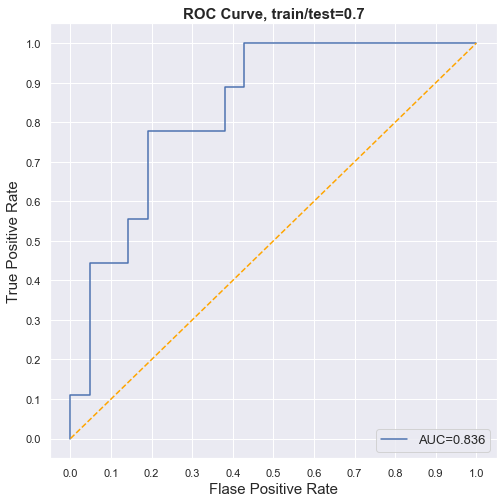

Done!


In [75]:
from mrp7pred.mrp7pred import MRP7Pred
from mrp7pred.grid import grid_light, grid_light_imbalance

m7p = MRP7Pred(train_new = True)
m7p.auto_train_test(
    df = df_sub_merged,
    grid = grid_light,
    model_dir = ".",
    feats_dir = ".",
    train_test_ratio = 0.7,
    featurized = True,
#     random_state = 1214,
    prefix = "nsc_substrate_mix_103_",
    time_limit=15,
    scoring='f1',
)
clf = m7p.clf_best

In [71]:
df_unk = pd.read_csv("./featurized_unknown__full_features_828_20210206-132138.csv", index_col=0)
df_unk

,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,rdk_NumAliphaticRings,rdk_NumAromaticCarbocycles,...,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8,name,smiles
0,0.250000,33,441.749,3,8,3,0,0,0,2,...,3.424,3.643,3.663,3.678,3.775,3.713,3.438,3.179,Citarinostat,O=C(CCCCCCNC(=O)c1cnc(N(c2ccccc2)c2ccccc2Cl)nc...
1,0.083333,21,298.215,1,8,2,0,0,0,1,...,2.934,3.173,3.062,3.005,2.977,2.858,2.673,2.456,Nitazoxanide,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1
2,0.181818,28,350.276,2,6,5,0,1,1,1,...,3.362,3.707,3.748,3.724,3.779,3.764,3.591,3.219,Galunisertib,Cc1cccc(-c2nn3c(c2-c2ccnc4ccc(C(N)=O)cc24)CCC3)n1
3,0.280000,37,522.218,3,9,4,0,1,1,2,...,3.523,3.851,3.916,3.784,3.701,3.703,3.626,3.474,Ensartinib,CC(Oc1cc(C(=O)Nc2ccc(C(=O)N3CCN(C)CC3)cc2)nnc1...
4,0.260870,30,385.269,3,6,5,1,0,1,2,...,3.373,3.663,3.630,3.575,3.582,3.555,3.498,3.300,Anlotinib,COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ccnc2cc1OCC1(N)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.363636,31,422.718,1,7,4,0,1,1,2,...,3.329,3.630,3.658,3.497,3.478,3.485,3.488,3.393,Gefitinib,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1
73,0.272727,29,370.259,1,7,3,0,0,0,2,...,3.234,3.502,3.564,3.478,3.522,3.547,3.491,3.318,Erlotinib,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
74,0.240000,35,490.220,2,7,5,0,1,1,2,...,3.526,3.872,3.961,3.905,3.806,3.700,3.569,3.455,FRAX486,CCn1c(=O)c(-c2ccc(Cl)cc2Cl)cc2cnc(Nc3ccc(N4CCN...
75,0.066667,22,304.651,2,5,3,0,0,0,1,...,3.060,3.348,3.372,3.324,3.276,3.192,2.941,2.447,AZD4635,Cc1cc(-c2nnc(N)nc2-c2ccc(F)cc2)cc(Cl)n1


In [76]:
result_df = m7p.predict(
        compound_df = df_unk,
        featurized_df = df_unk,
        prefix = "unknown_merged_103_",
        out_dir = "."
    )

Start predicting ... Done!
Writing output ... Done! Results saved to: ./unknown_merged_103_predicted_20210306-190206.csv


In [73]:
# test on known dataset
df_man = pd.read_csv("./man_full_features_828_20210115-085233.csv", index_col=0)
df_man = df_man.rename(columns={"std_smiles":"smiles"})
df_man

,name,smiles,rdk_FractionCSP3,rdk_HeavyAtomCount,rdk_HeavyAtomMolWt,rdk_NHOHCount,rdk_NOCount,rdk_RingCount,rdk_NumAliphaticCarbocycles,rdk_NumAliphaticHeterocycles,...,pychem_ATSe7,pychem_ATSe8,pychem_ATSp1,pychem_ATSp2,pychem_ATSp3,pychem_ATSp4,pychem_ATSp5,pychem_ATSp6,pychem_ATSp7,pychem_ATSp8
0,paclitaxel,CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(...,0.446809,62.0,802.510,4.0,15.0,7.0,3.0,1.0,...,5.327,5.184,4.058,4.421,4.610,4.691,4.805,4.894,4.829,4.748
1,vincristine,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.565217,60.0,768.524,3.0,14.0,9.0,1.0,5.0,...,5.285,5.159,4.047,4.528,4.759,4.967,4.988,4.985,4.913,4.799
2,LTC4,CCCCCC=CCC=CC=CC=CC(SCC(NC(=O)CCC(N)C(=O)O)C(=...,0.566667,43.0,578.409,8.0,12.0,0.0,0.0,0.0,...,4.247,4.316,3.625,3.715,3.760,3.789,3.831,3.863,3.902,3.888
3,E217bG,CC12CCC3c4ccc(O)cc4CCC3C1CCC2OC1OC(C(=O)O)C(O)...,0.708333,32.0,416.256,5.0,8.0,5.0,3.0,1.0,...,3.890,3.811,3.451,3.843,3.915,3.791,3.648,3.590,3.502,3.258
4,gemcitabine,Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1,0.555556,18.0,252.112,4.0,7.0,2.0,0.0,1.0,...,2.614,1.615,2.614,2.903,2.835,2.645,2.489,2.138,1.619,0.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,CCTA-46,O=C(Nc1cccc(-c2cc(F)c(F)c(F)c2)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,3.181,2.877,3.003,3.278,3.198,3.060,3.078,2.892,2.650,2.399
113,CCTA-47,O=C(Nc1cccc(-c2cc(F)ccc2F)c1)C(Cl)Cl,0.071429,20.0,307.062,1.0,2.0,2.0,0.0,0.0,...,2.969,2.807,2.987,3.254,3.177,3.055,3.067,2.849,2.590,2.365
114,CCTA-48,O=C(Nc1cccc(-c2ccc(F)c(F)c2F)c1)C(Cl)Cl,0.071429,21.0,326.060,1.0,2.0,2.0,0.0,0.0,...,3.108,2.981,3.003,3.278,3.211,3.075,3.078,2.885,2.636,2.412
115,CCTA-49,O=C(Nc1cccc(-c2ccc(-c3ccccc3)c(F)c2)c1)C(Cl)Cl,0.050000,25.0,360.130,1.0,2.0,3.0,0.0,0.0,...,3.297,3.192,3.277,3.563,3.536,3.431,3.414,3.222,3.091,3.035


In [78]:
result_df = m7p.predict(
        compound_df = df_man,
        featurized_df = df_man,
        prefix = "man_merged_103_",
        out_dir = "."
    )

Start predicting ... Done!
Writing output ... Done! Results saved to: ./man_merged_103_predicted_20210306-190235.csv
